# Compound Finance Market Analysis

### Import Required Libraries

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from web3 import Web3
import json
from datetime import datetime

### Setup Web3 Connection

In [9]:
infura_url = "https://mainnet.infura.io/v3/cefa0b447f1a46ecbba9615b4b7e5a26"
web3 = Web3(Web3.HTTPProvider(infura_url))

### Load ABI and Create Contract Instance

In [10]:
with open('cUSDCv3_abi.json') as f:
    abi = json.load(f)
contract = web3.eth.contract(
    address="0xc3d688B66703497DAA19211EEdff47f25384cdc3", 
    abi=abi
)

### Part 1: Market Asset Information

In [11]:
def get_market_assets():
    """
    Get information about base asset and collateral assets in the lending market
    """
    print("\nMarket Assets Information:")
    print("-" * 50)
    
    # Get base token
    base_token = contract.functions.baseToken().call()
    print(f"\nBase Asset: {base_token}")
    
    # Get number of collateral assets
    num_assets = contract.functions.numAssets().call()
    print(f"\nNumber of collateral assets: {num_assets}")
    
    print("\nCollateral Assets:")
    for i in range(num_assets):
        asset_info = contract.functions.getAssetInfo(i).call()
        collateral_reserves = contract.functions.getCollateralReserves(asset_info[1]).call()
        print(f"\nAsset {i+1}:")
        print(f"Address: {asset_info[1]}")
        print(f"Amount in reserves: {collateral_reserves}")

In [12]:
# Get current market information
print("Getting market assets information...")
get_market_assets()

Getting market assets information...

Market Assets Information:
--------------------------------------------------

Base Asset: 0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48

Number of collateral assets: 8

Collateral Assets:

Asset 1:
Address: 0xc00e94Cb662C3520282E6f5717214004A7f26888
Amount in reserves: 5947972926608043

Asset 2:
Address: 0x2260FAC5E5542a773Aa44fBCfeDf7C193bc2C599
Amount in reserves: 9591

Asset 3:
Address: 0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2
Amount in reserves: 82711473284335

Asset 4:
Address: 0x1f9840a85d5aF5bf1D1762F925BDADdC4201F984
Amount in reserves: 3025028733646861255

Asset 5:
Address: 0x514910771AF9Ca656af840dff83E8264EcF986CA
Amount in reserves: 553216641690544201

Asset 6:
Address: 0x7f39C581F595B53c5cb19bD0b3f8dA6c935E2Ca0
Amount in reserves: 69032885455

Asset 7:
Address: 0xcbB7C0000aB88B473b1f5aFd9ef808440eed33Bf
Amount in reserves: 0

Asset 8:
Address: 0x18084fbA666a33d37592fA2633fD49a74DD93a88
Amount in reserves: 0


### Part 2: Historical Data Collection

In [14]:
def fetch_metrics(block_number):
    """
    Fetch metrics from the Compound contract for a specific block number
    """
    try:
        # Fetch raw metrics
        total_borrow = contract.functions.totalBorrow().call(block_identifier=block_number)
        total_supply = contract.functions.totalSupply().call(block_identifier=block_number)
        reserves = contract.functions.getReserves().call(block_identifier=block_number)
        utilization = contract.functions.getUtilization().call(block_identifier=block_number)
        
        # Calculate loan-to-deposit ratio using total supply
        loan_to_deposit_ratio = (total_borrow / total_supply) * 100 if total_supply > 0 else 0
        
        # Get block timestamp
        timestamp = web3.eth.get_block(block_number)['timestamp']
        date = datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')

        # Normalize values (USDC has 6 decimals)
        normalized_utilization = utilization / 10**18  # Utilization is in 18 decimals

        return {
            'date': date,
            'block': block_number,
            'total_borrow': total_borrow / 10**6,
            'total_supply': total_supply / 10**6,
            'loan_to_deposit_ratio': loan_to_deposit_ratio,
            'utilization': normalized_utilization * 100,
            'reserves': reserves / 10**6
        }
    except Exception as e:
        print(f"Error fetching data for block {block_number}: {str(e)}")
        return None

In [13]:
# Define blocks to analyze
blocks = [
    18242720,  # Sep-29-2023
    18903241,  # Dec-31-2023
    19551663,  # Mar-31-2024
    20202271,  # Jun-30-2024
    web3.eth.block_number  # Current block
]

### Part 3: Data Collection and Visualization

In [15]:
# Collect metrics for all blocks
metrics_data = []
for block in blocks:
    metrics = fetch_metrics(block)
    if metrics:
        metrics_data.append(metrics)
        print(f"\nMetrics for block {block} ({metrics['date']}):")
        for key, value in metrics.items():
            if key not in ['date', 'block']:
                print(f"{key}: {value:,.2f}")


Metrics for block 18242720 (2023-09-29):
total_borrow: 290,057,744.38
total_supply: 337,994,695.30
loan_to_deposit_ratio: 85.82
utilization: 85.82
reserves: 3,115,843.94

Metrics for block 18903241 (2023-12-30):
total_borrow: 366,211,819.04
total_supply: 386,989,144.78
loan_to_deposit_ratio: 94.63
utilization: 94.63
reserves: 3,664,389.42

Metrics for block 19551663 (2024-03-31):
total_borrow: 494,754,852.02
total_supply: 534,004,706.65
loan_to_deposit_ratio: 92.65
utilization: 92.65
reserves: 6,072,939.25

Metrics for block 20202271 (2024-06-30):
total_borrow: 495,000,991.14
total_supply: 558,569,320.56
loan_to_deposit_ratio: 88.62
utilization: 88.62
reserves: 8,787,999.74

Metrics for block 21096579 (2024-11-01):
total_borrow: 390,691,548.13
total_supply: 425,967,386.03
loan_to_deposit_ratio: 91.72
utilization: 91.72
reserves: 10,097,072.99


In [16]:
# Create DataFrame
df = pd.DataFrame(metrics_data)
df.set_index('date', inplace=True)

### Part 4: Visualizations

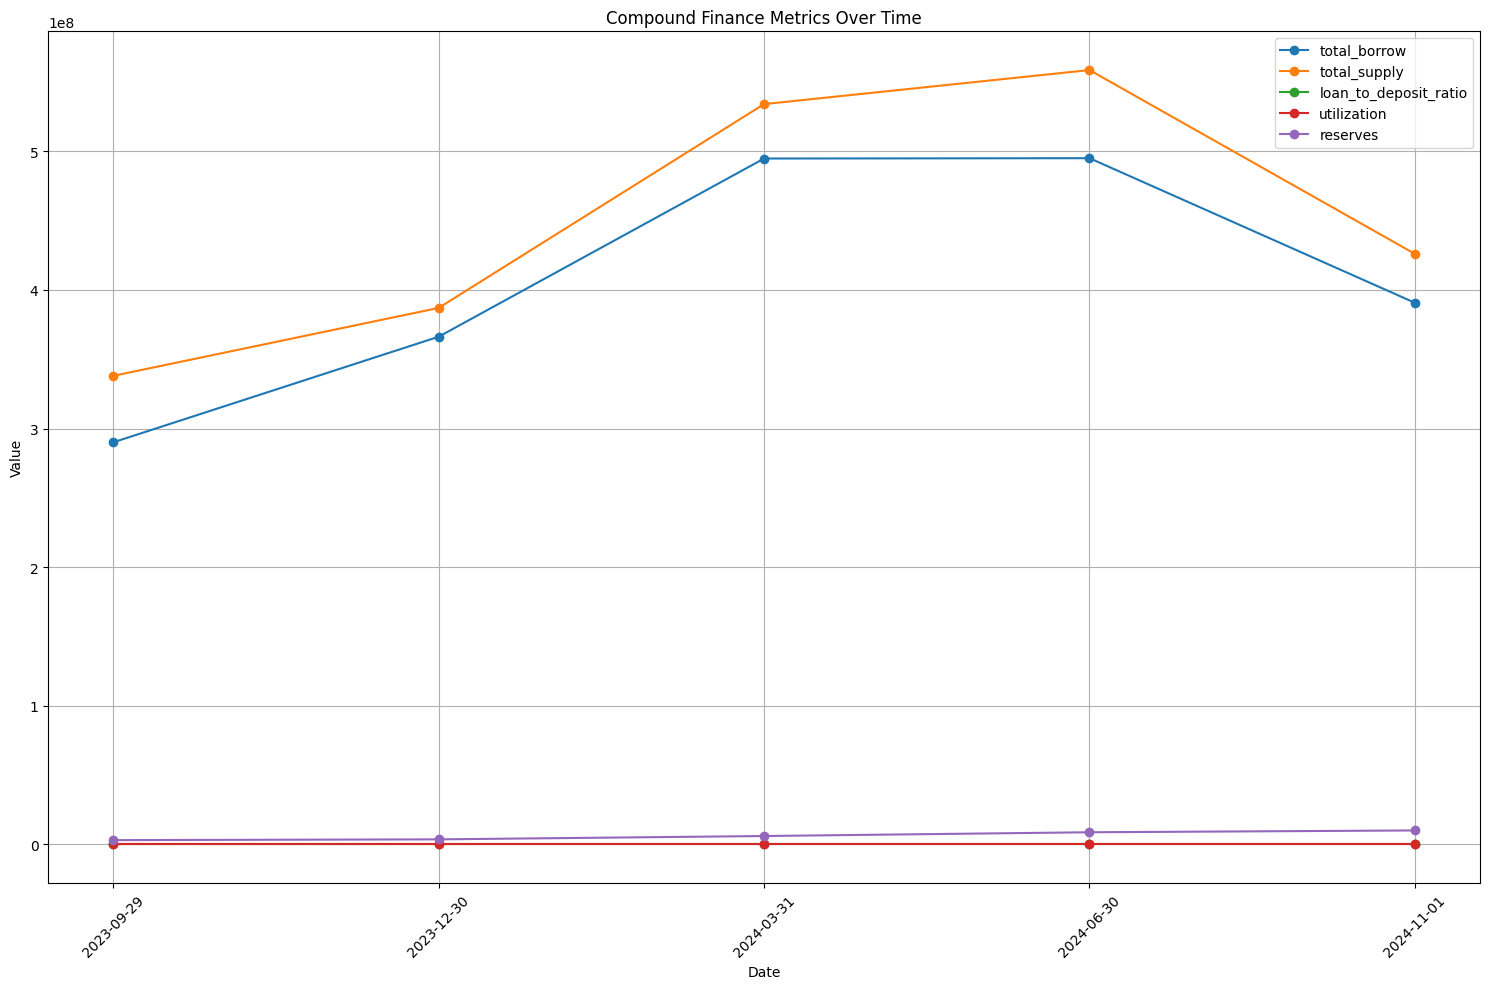

In [17]:
# Create line plots
plt.figure(figsize=(15, 10))
metrics = ['total_borrow', 'total_supply', 'loan_to_deposit_ratio', 'utilization', 'reserves']
for metric in metrics:
    plt.plot(df.index, df[metric], marker='o', label=metric)

plt.title('Compound Finance Metrics Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

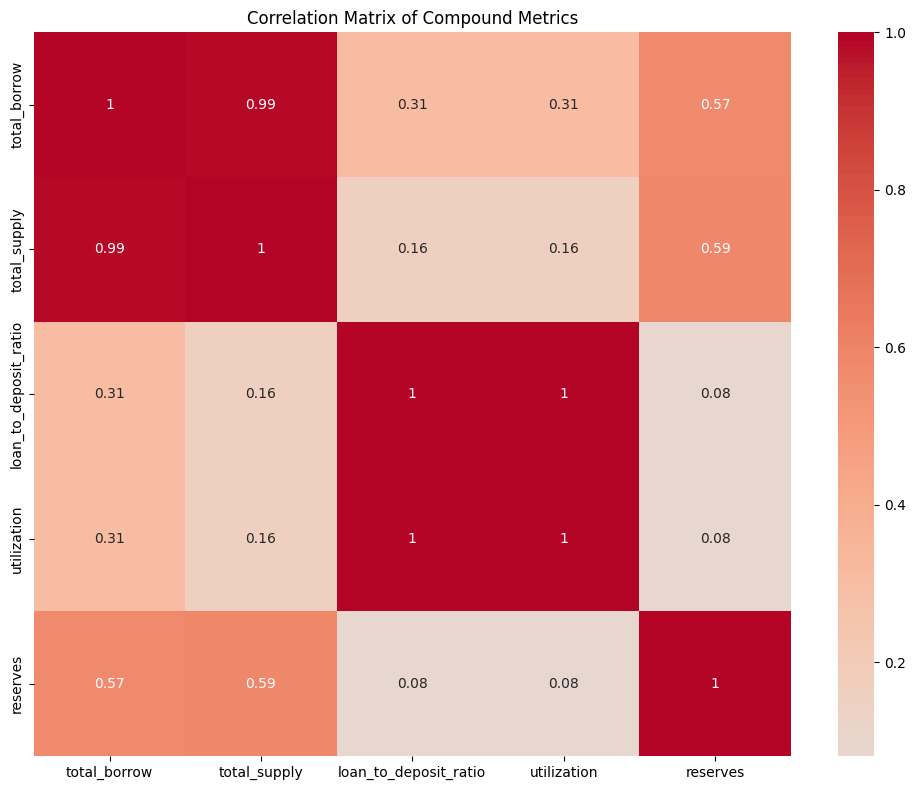

In [18]:
# Create correlation matrix heatmap
correlation_matrix = df.drop('block', axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Compound Metrics')
plt.tight_layout()
plt.show()

### Part 5: Analysis Results

In [20]:
print("\nFinal Metrics DataFrame:")
print(df)


Final Metrics DataFrame:
               block  total_borrow  total_supply  loan_to_deposit_ratio  \
date                                                                      
2023-09-29  18242720  2.900577e+08  3.379947e+08              85.817248   
2023-12-30  18903241  3.662118e+08  3.869891e+08              94.631031   
2024-03-31  19551663  4.947549e+08  5.340047e+08              92.649905   
2024-06-30  20202271  4.950010e+08  5.585693e+08              88.619438   
2024-11-01  21096579  3.906915e+08  4.259674e+08              91.718653   

            utilization      reserves  
date                                   
2023-09-29    85.817242  3.115844e+06  
2023-12-30    94.631021  3.664389e+06  
2024-03-31    92.649818  6.072939e+06  
2024-06-30    88.619305  8.788000e+06  
2024-11-01    91.718632  1.009707e+07  


In [21]:
# Save to CSV
df.to_csv('compound_metrics.csv')